## 패키지 로딩하기

In [38]:
from IPython.display import Image as show_gif

import os
import cv2
import imageio
import numpy as np
import tensorflow as tf
import PIL.Image as Image
import matplotlib.pyplot as plt

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1
#### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
#### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다. cv2.resize()를 사용하면 된다.
#### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽다.
#### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. 마찬가지로 cv2.resize()를 사용하면 된다.
#### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해야한다. 이전 시각화에 사용했던 코드를 참고하면 된다.
#### 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명을 해보자. (정답은 없다)

* 1. (적당히) 높은 해상도를 가진 이미지를 검색하고 한 장 고룬 후 저장하고 불러온다.

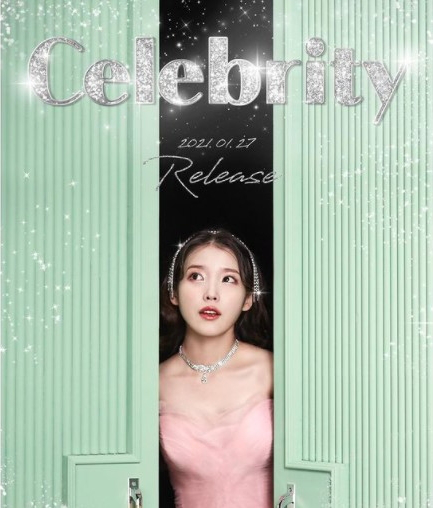

In [2]:
img_path = os.getenv("HOME") + "/aiffel/super_resolution/image_2.jpeg"
temp_img = Image.open(img_path)
img_orig = np.array(temp_img)
temp_img

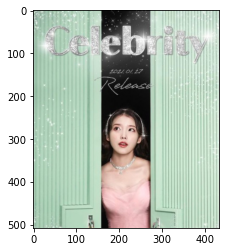

In [3]:
plt.imshow(img_orig)
plt.show()

* 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.

In [4]:
img_shape   = img_orig.shape[:2]
img_bicubic = cv2.resize(img_orig, dsize = (int(img_shape[1] / 4), int(img_shape[0] / 4)), interpolation = cv2.INTER_CUBIC)

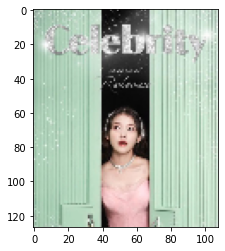

In [5]:
plt.imshow(img_bicubic)
plt.show()

* 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

In [6]:
# srgan_G.h5 파일은 학습이 완료된 Generator이며, 이를 다운로드 받아 코드를 실행해 학습 완료된 모델을 불러온다.
model_path = os.getenv("HOME") + "/aiffel/super_resolution/srgan_G.h5"
srgan      = tf.keras.models.load_model(model_path)

In [7]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr    = srgan.predict(image)
    st    = tf.clip_by_value(sr, 0, 255)
    sr    = tf.round(sr)
    sr    = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

img_srgan = apply_srgan(img_bicubic)

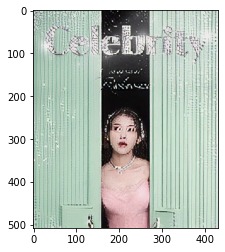

In [8]:
plt.imshow(img_srgan)
plt.show()

* 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

In [9]:
img_resize = cv2.resize(img_bicubic, dsize = (img_shape[1], img_shape[0]), interpolation = cv2.INTER_CUBIC)

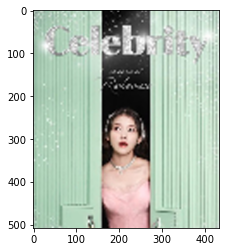

In [10]:
plt.imshow(img_resize)
plt.show()

* 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화한다.

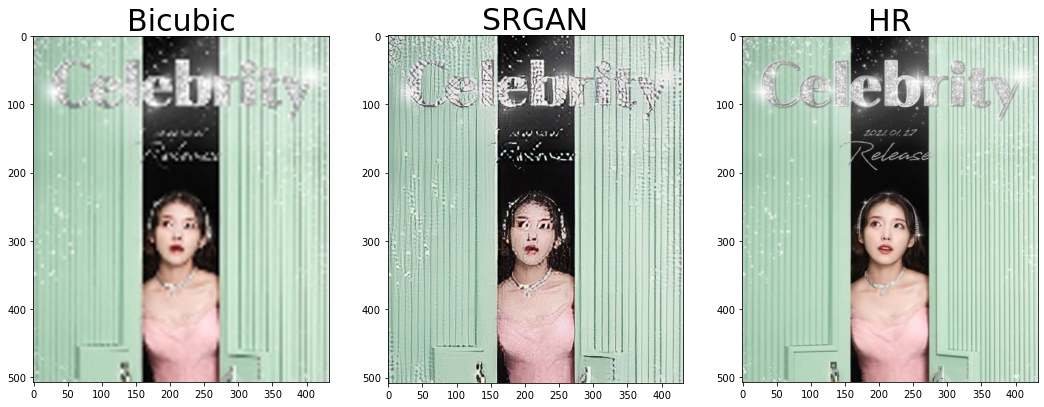

In [11]:
images = [img_resize, img_srgan, img_orig]
labels = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize = (18, 18))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize = 30)

In [12]:
# 이미지의 특정 부분을 잘라내는 함수를 정의한다.
def crop(image, left_top, x = 200, y = 200):
    return image[left_top[0]:(left_top[0] + x), left_top[1]:(left_top[1] + y), :]

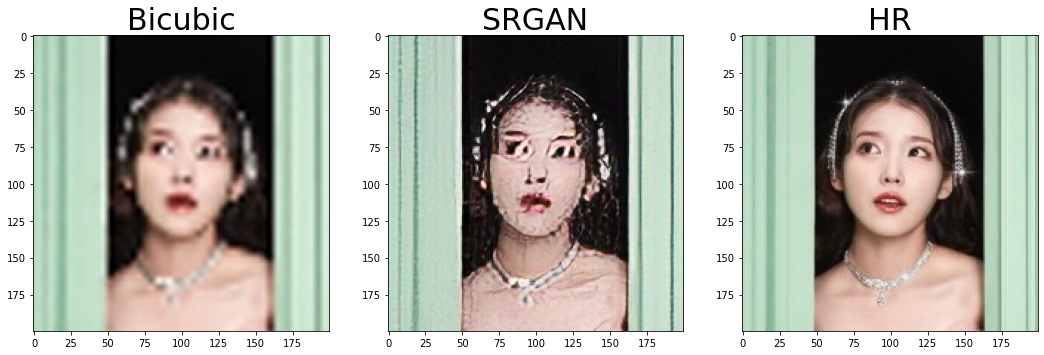

In [13]:
# 자세한 시각화를 하기 위해 영역을 잘라낸다.
# 아래는 잘라낸 부분의 좌상단 좌표이다.
left_top = (200, 110)

img1 = crop(img_resize, left_top, 200, 200)
img2 = crop(img_srgan,  left_top, 200, 200)
img3 = crop(img_orig,   left_top, 200, 200)

images = [img1, img2, img3]
labels = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize = (18, 18))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize = 30)

* 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명을 해보자.

In [14]:
# DIV2K 데이터셋의 이미지들에는 화려한 물건이나 반짝이는 보석도 없는 듯 하고, 황색 인물이 없는것 같다.
# 뒤에 머리카락과 검은색 배경을 구분을 못한 모습이 보인다.
# 아이유처럼 미인도 없는듯....

### 프로젝트 1-2.

#### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
#### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽다.
#### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다. cv2.resize()를 사용하면 된다.
#### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않다.
#### 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해보자. (정답은 없다.)

* 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.

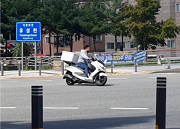

In [15]:
img2_path = os.getenv("HOME") + "/aiffel/super_resolution/image_3.jpg"
temp_img2 = Image.open(img2_path)
img2_orig = np.array(temp_img2)
temp_img2

* 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

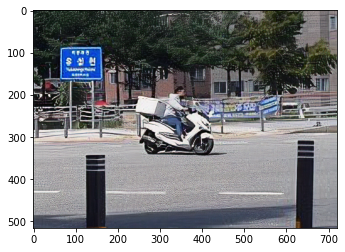

In [16]:
img2_srgan = apply_srgan(img2_orig)

plt.imshow(img2_srgan)
plt.show()

* 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

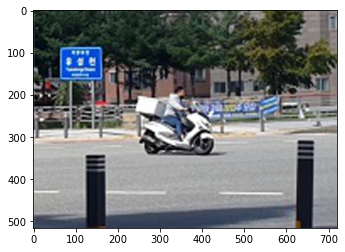

In [17]:
img2_shape = img2_orig.shape[:2]
img2_resize = cv2.resize(img2_orig, dsize = (img2_shape[1] * 4, img2_shape[0] * 4), interpolation = cv2.INTER_CUBIC)

plt.imshow(img2_resize)
plt.show()

* 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다.

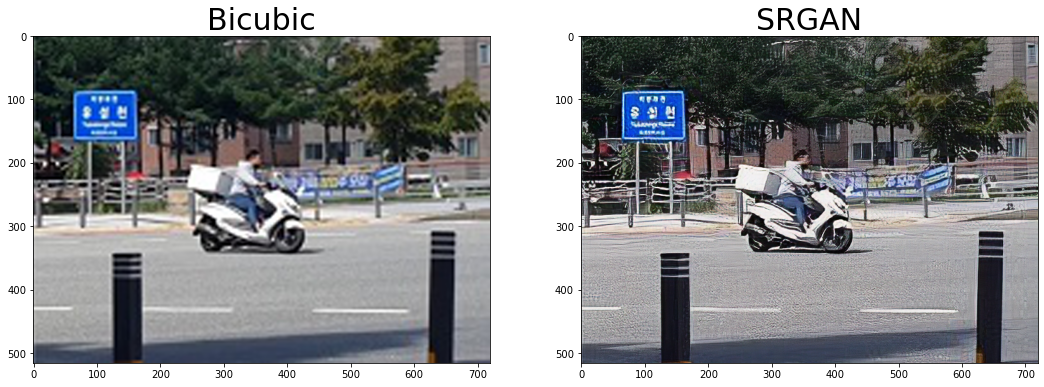

In [18]:
images = [img2_resize, img2_srgan]
labels = ["Bicubic", "SRGAN"]

plt.figure(figsize = (18, 18))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize = 30)

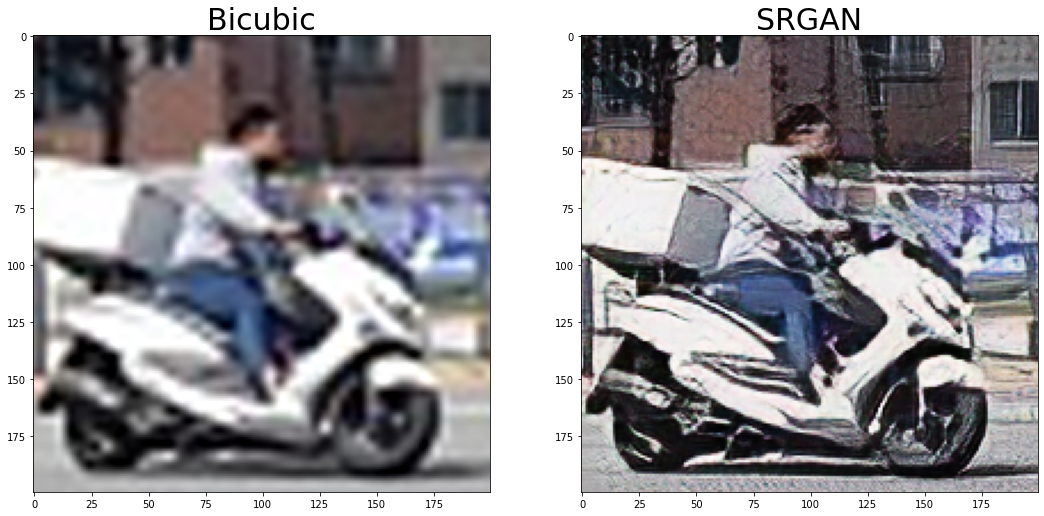

In [19]:
# 자세한 시각화를 하기 위해 영역을 잘라낸다.
# 아래는 잘라낸 부분의 좌상단 좌표이다.
left_top = (150, 250)

img1 = crop(img2_resize, left_top, 200, 200)
img2 = crop(img2_srgan,  left_top, 200, 200)

images = [img1, img2]
labels = ["Bicubic", "SRGAN"]

plt.figure(figsize = (18, 18))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize = 30)

* 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해보자.

In [20]:
# 사람과 비교해보면 오토바이는 SRGAN이 잘 복원한 듯 하나 바람에 휘날리는 머리와 사람의 옆모습은 제대로 복원하지 못한 듯 하다.
# 그리고 옷의 경우는 상의와 하의는 잘 구분한 듯 하나, 신발은 오토바이와 구분을 못한 모습이 보인다.
# 뒤에 나무와 건물은 그나마 잘 복원한 듯 하나, 전단지에 경우에는 구현하지 못했다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

#### 1. gif 파일 불러오기
* 다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있다.
* frames이란 리스트 안에 각각의 프레임이 들어 있다.

In [48]:
# 다운받은 파일의 경로를 설정해준다.
gif_path = os.getenv("HOME") + "/aiffel/super_resolution/wine_lr.gif"

gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []

while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        
print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (340, 355, 3)


#### 2. 프레임별 Super Resolution 진행하기

* SRGAN

In [49]:
frames_sr = []

for frame in frames:
    frame_sr = apply_srgan(frame)
    frames_sr.append(frame_sr)
    
print("frames_sr 수 :", len(frames_sr))
print("frames_sr 크기 :", (frames_sr[0].shape))

frames_sr 수 : 13
frames_sr 크기 : (1360, 1420, 3)


* Bicubic interpolation

In [50]:
frame_shape = frames[0].shape[:2]
frames_sr2  = []

for frame in frames:
    frame_resize = cv2.resize(frame, dsize = (frame_shape[1] * 4, frame_shape[0] * 4), interpolation = cv2.INTER_CUBIC)
    frames_sr2.append(frame_resize)
    
print("frames_sr 수 :", len(frames_sr2))
print("frames_sr 크기 :", (frames_sr2[0].shape))

frames_sr 수 : 13
frames_sr 크기 : (1360, 1420, 3)


#### 3. 프레임을 합쳐 gif 만들기

* SRGAN으로 만든 이미지로 만든 gif

In [51]:
gif2_path = os.getenv("HOME") + "/aiffel/super_resolution/srgan_gif.gif"
imageio.mimsave(gif2_path, frames_sr)

* Bicubic interpolation으로 만든 이미지로 만든 gif

In [52]:
gif3_path = os.getenv("HOME") + "/aiffel/super_resolution/bicubic_gif.gif"
imageio.mimsave(gif3_path, frames_sr2)

#### 4. Jupyter notebook에 gif 표시하기

* 저해상도의 gif : 주피터노트북에서 움짤처럼 되지 않고, 사진처럼 안 움직인다.
* SRGAN으로 만든 이미지로 만든 gif : 26mb로 블로그와 깃허브 전부 올라가지 않는다.
* Bicubic interpolation으로 만든 이미지로 만든 gif : 이상없다.

#### 나머지 gif들로도 시도해봤으나, 저해상도 gif가 블로그와 깃허브에서 전부 움직이지 않는다.

## 회고록

In [1]:
# 오늘은 사진을 크게 보간하는 방법에 대해서 배웠는데
# 실습을 마치고 나니까 개념이 제일 어려웠던것 같다.
# 아마 모델을 직접 구현하는 게 아니라 이미 잘 학습된 모델을 다운받아서 그냥 사용해서 그런 것 같다.
# cs231n에서 말했던 잘 학습된 model을 다운받아서 사용하면 된다는 말이 이렇게 편리한 것인지 몰랐는데 너무 편했다.

# 오랜만에 GAN에 대해서 봤는데, 다시 개념이 흔들리다가 조원들과 대화를 통해 다시 개념을 잡았다.

# 사진은 만족스럽지는 않지만 각 기법마다 복원된 사진의 특징이 보여서 다행이였다.
# 둘 다 불은 같아보이나, SRGAN은 밑에 나뭇잎에 선 같은것이 있어서 나뭇잎을 자세히 복원한 것 같고, bicubic은 나뭇잎이 흐리게 나왔다.
# gif에서 한 가지 문제가 있는데 저해상도는 움직이지 않고, 고해상도만 움직인다.
# 다른 gif 파일들도 저해상도가 안 움직인다.